In [7]:
import pandas as pd
import numpy as np
import json
import pandas as pd
from cobra import Model, Reaction, Metabolite
from cobra.flux_analysis import flux_variability_analysis
import pickle
from tqdm import tqdm 
from ast import literal_eval
import cobra
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
from functools import partial 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
import multiprocessing as mp
import gurobipy
gurobipy.setParam('OutputFlag', 0)
import sys
sys.path.append('../retrosynthesis/')

from common import *


### input and output

In [8]:
###input
yeast870_path =  '../../Data/model/yeast-GEM902.yml'

yeast8U_path = '../../Data/model/Yeast-MetaTwin.yml'
essential_genes_path = '../../Data/model/essential_genes.json'
not_essential_genes_path = '../../Data/model/not_essential_genes.json'

###output
gene_essential_yeast9gene_confusion_matrix_figure_path = '../../Results/Figures/figs9-b.pdf'
gene_essential_allgene_confusion_matrix_figure_path = '../../Results/Figures/figs9-c.pdf'
# _confusion_matrix_figure_path = '../../Results/Figures/figs9-b.pdf'

In [9]:
with open(essential_genes_path) as f:
    essential_genes = json.load(f)
with open(not_essential_genes_path) as f:
    not_essential_genes = json.load(f)

In [10]:
def get_accuracy_and_confusion_matrix_num(essential_predict_list,notessential_predict_list,essential_genes,not_essential_genes):
    TP = len(set(essential_predict_list) & set(essential_genes))
    TN = len(set(notessential_predict_list) & set(not_essential_genes))
    FP = len(set(essential_predict_list) - set(essential_genes))
    FN = len(set(notessential_predict_list) - set(not_essential_genes))
    Accuracy = round((TP + TN) / (TP + TN + FP + FN), 3)
    print(Accuracy)
    return TP,TN,FP,FN,Accuracy



In [11]:
def draw_confusion_matrix_figure(yeast8_TP, yeast8_TN, yeast8_FP, yeast8_FN, yeast8_Accuracy, 
                                 yeast8U_TP, yeast8U_TN, yeast8U_FP, yeast8U_FN, yeast8U_Accuracy, 
                                 figure_path, vmax):
    # Assume you have two sets of confusion matrix data
    confusion_matrix1 = np.array([[yeast8_TP, yeast8_FP], [yeast8_FN, yeast8_TN]])
    confusion_matrix2 = np.array([[yeast8U_TP, yeast8U_FP], [yeast8U_FN, yeast8U_TN]])

    # Create a figure, set the subplot layout to 1 row and 2 columns, with the right subplot being narrower
    fig = plt.figure(figsize=(2, 1.6), dpi=400)
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['pdf.fonttype'] = 42
    
    gs = GridSpec(1, 3, width_ratios=[0.6, 0.6, 0.03])

    # First subplot
    ax1 = plt.subplot(gs[0])
    im1 = ax1.imshow(confusion_matrix1, cmap='Wistia', interpolation='nearest', vmin=1, vmax=vmax, aspect=2)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.grid(False)
    ax1.text(0, 0, f"TP\n{confusion_matrix1[0, 0]}", ha='center', va='center', fontsize=8, color='black')
    ax1.text(1, 0, f"FP\n{confusion_matrix1[0, 1]}", ha='center', va='center', fontsize=8, color='black')
    ax1.text(0, 1, f"FN\n{confusion_matrix1[1, 0]}", ha='center', va='center', fontsize=8, color='black')
    ax1.text(1, 1, f"TN\n{confusion_matrix1[1, 1]}", ha='center', va='center', fontsize=8, color='black')
    ax1.set_xlabel(f"Yeast9\n(ACC = {yeast8_Accuracy:.2f})", fontsize=8, labelpad=-1)
    # Add border to the image
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0)

    # Second subplot
    ax2 = plt.subplot(gs[1])
    im2 = ax2.imshow(confusion_matrix2, cmap='Wistia', interpolation='nearest', vmin=1, vmax=vmax, aspect=2)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.grid(False)
    ax2.text(0, 0, f"TP\n{confusion_matrix2[0, 0]}", ha='center', va='center', fontsize=8, color='black')
    ax2.text(1, 0, f"FP\n{confusion_matrix2[0, 1]}", ha='center', va='center', fontsize=8, color='black')
    ax2.text(0, 1, f"FN\n{confusion_matrix2[1, 0]}", ha='center', va='center', fontsize=8, color='black')
    ax2.text(1, 1, f"TN\n{confusion_matrix2[1, 1]}", ha='center', va='center', fontsize=8, color='black')
    ax2.set_xlabel(f"Yeast-MetaTwin\n(ACC = {yeast8U_Accuracy:.2f})", fontsize=8, labelpad=-1)
    # Add border to the image
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0)

    # Color bar
    cbar_ax = plt.subplot(gs[2])
    cbar = fig.colorbar(im2, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=6)
    cbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
    # Add border to the image
    for spine in cbar_ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0)

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.02)
    # Save the image to a file
    plt.savefig(figure_path, dpi=400, bbox_inches='tight')
    plt.show()

In [12]:
yeast8_essential_predict_list,yeast8_notessential_predict_list = GEM_gene_essential(yeast870_path)
yeast8U_essential_predict_list_plus,yeast8U_notessential_predict_list_plus = GEM_gene_essential(yeast8U_path)

100%|██████████| 1582/1582 [06:11<00:00,  4.26it/s]


In [13]:
yeast8U_essential_predict_list_plus_old = [x for x in yeast8U_essential_predict_list_plus if x in yeast8_essential_predict_list or x in yeast8_notessential_predict_list]
yeast8U_notessential_predict_list_plus_old = [x for x in yeast8U_notessential_predict_list_plus if x in yeast8_essential_predict_list or x in yeast8_notessential_predict_list]
print(len(yeast8U_essential_predict_list_plus),len(yeast8U_notessential_predict_list_plus))
print(len(yeast8U_essential_predict_list_plus_old),len(yeast8U_notessential_predict_list_plus_old))


yeast8_TP,yeast8_TN,yeast8_FP,yeast8_FN,yeast8_Accuracy = get_accuracy_and_confusion_matrix_num(yeast8_essential_predict_list,yeast8_notessential_predict_list,essential_genes,not_essential_genes)
yeast8U_TP,yeast8U_TN,yeast8U_FP,yeast8U_FN,yeast8U_Accuracy= get_accuracy_and_confusion_matrix_num(yeast8U_essential_predict_list_plus,yeast8U_notessential_predict_list_plus,essential_genes,not_essential_genes)
print(yeast8_TP,yeast8_TN,yeast8_FP,yeast8_FN,yeast8_Accuracy)
print(yeast8U_TP,yeast8U_TN,yeast8U_FP,yeast8U_FN,yeast8U_Accuracy)

yeast8_TP,yeast8_TN,yeast8_FP,yeast8_FN,yeast8_Accuracy = get_accuracy_and_confusion_matrix_num(yeast8_essential_predict_list,yeast8_notessential_predict_list,essential_genes,not_essential_genes)
yeast8U_TP,yeast8U_TN,yeast8U_FP,yeast8U_FN,yeast8U_Accuracy= get_accuracy_and_confusion_matrix_num(yeast8U_essential_predict_list_plus_old,yeast8U_notessential_predict_list_plus_old,essential_genes,not_essential_genes)
print(yeast8_TP,yeast8_TN,yeast8_FP,yeast8_FN,yeast8_Accuracy)
print(yeast8U_TP,yeast8U_TN,yeast8U_FP,yeast8U_FN,yeast8U_Accuracy)

126 1456
126 1035
0.879
0.904
77 943 104 37 0.879
71 1359 55 97 0.904
0.879
0.921
77 943 104 37 0.879
71 998 55 37 0.921


meta NOT subset; don't know how to subset; dropped


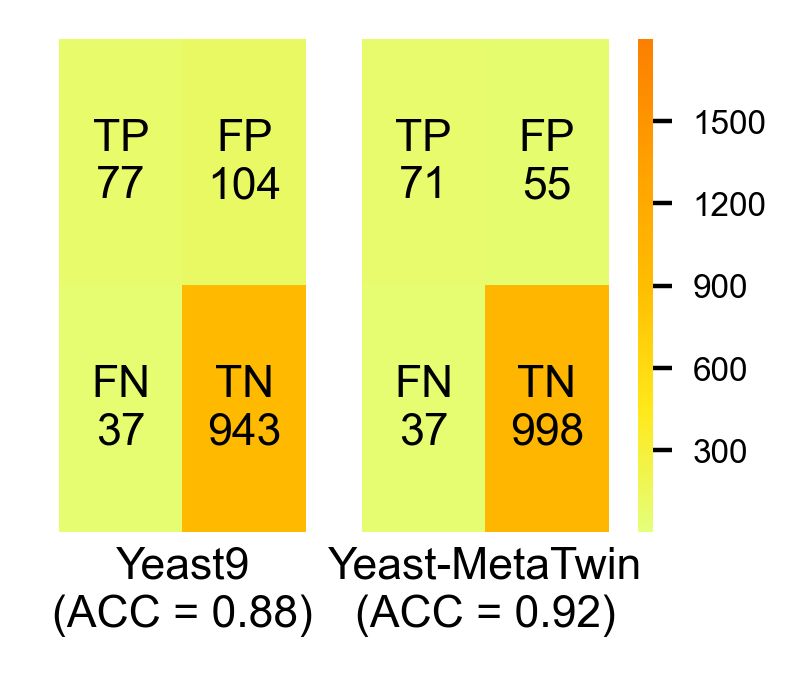

In [14]:
draw_confusion_matrix_figure(yeast8_TP,yeast8_TN,yeast8_FP,yeast8_FN,yeast8_Accuracy,yeast8U_TP,yeast8U_TN,yeast8U_FP,yeast8U_FN,
                             yeast8U_Accuracy,gene_essential_yeast9gene_confusion_matrix_figure_path,vmax=1799)

## all gene essential

In [15]:
def draw_confusion_matrix_figure(yeast8_TP, yeast8_TN, yeast8_FP, yeast8_FN, yeast8_Accuracy, 
                                 yeast8U_TP, yeast8U_TN, yeast8U_FP, yeast8U_FN, yeast8U_Accuracy, 
                                 figure_path, vmax):
    # Assume you have two sets of confusion matrix data
    confusion_matrix1 = np.array([[yeast8_TP, yeast8_FP], [yeast8_FN, yeast8_TN]])
    confusion_matrix2 = np.array([[yeast8U_TP, yeast8U_FP], [yeast8U_FN, yeast8U_TN]])

    # Create a figure, set the subplot layout to 1 row and 2 columns, with the right subplot being narrower
    fig = plt.figure(figsize=(2, 1.6), dpi=400)
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['pdf.fonttype'] = 42
    
    gs = GridSpec(1, 3, width_ratios=[0.6, 0.6, 0.03])

    # First subplot
    ax1 = plt.subplot(gs[0])
    im1 = ax1.imshow(confusion_matrix1, cmap='Wistia', interpolation='nearest', vmin=1, vmax=vmax, aspect=2)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.grid(False)
    ax1.text(0, 0, f"TP\n{confusion_matrix1[0, 0]}", ha='center', va='center', fontsize=8, color='black')
    ax1.text(1, 0, f"FP\n{confusion_matrix1[0, 1]}", ha='center', va='center', fontsize=8, color='black')
    ax1.text(0, 1, f"FN\n{confusion_matrix1[1, 0]}", ha='center', va='center', fontsize=8, color='black')
    ax1.text(1, 1, f"TN\n{confusion_matrix1[1, 1]}", ha='center', va='center', fontsize=8, color='black')
    ax1.set_xlabel(f"Yeast9\n(ACC = {yeast8_Accuracy:.2f})", fontsize=8, labelpad=-1)
    # Add border to the image
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0)

    # Second subplot
    ax2 = plt.subplot(gs[1])
    im2 = ax2.imshow(confusion_matrix2, cmap='Wistia', interpolation='nearest', vmin=1, vmax=vmax, aspect=2)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.grid(False)
    ax2.text(0, 0, f"TP\n{confusion_matrix2[0, 0]}", ha='center', va='center', fontsize=8, color='black')
    ax2.text(1, 0, f"FP\n{confusion_matrix2[0, 1]}", ha='center', va='center', fontsize=8, color='black')
    ax2.text(0, 1, f"FN\n{confusion_matrix2[1, 0]}", ha='center', va='center', fontsize=8, color='black')
    ax2.text(1, 1, f"TN\n{confusion_matrix2[1, 1]}", ha='center', va='center', fontsize=8, color='black')
    ax2.set_xlabel(f"Yeast-MetaTwin\n(ACC = {yeast8U_Accuracy:.2f})", fontsize=8, labelpad=-1)
    # Add border to the image
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0)

    # Color bar
    cbar_ax = plt.subplot(gs[2])
    cbar = fig.colorbar(im2, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=6)
    cbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
    # Add border to the image
    for spine in cbar_ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0)

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.02)
    # Save the image to a file
    plt.savefig(figure_path, dpi=400, bbox_inches='tight')
    plt.show()

In [16]:
yeast8U_essential_predict_list_plus_all = [x for x in yeast8U_essential_predict_list_plus]
yeast8U_notessential_predict_list_plus_all = [x for x in yeast8U_notessential_predict_list_plus]
print(len(yeast8U_essential_predict_list_plus),len(yeast8U_notessential_predict_list_plus))
print(len(yeast8U_essential_predict_list_plus_all),len(yeast8U_notessential_predict_list_plus_all))


yeast8_TP,yeast8_TN,yeast8_FP,yeast8_FN,yeast8_Accuracy = get_accuracy_and_confusion_matrix_num(yeast8_essential_predict_list,yeast8_notessential_predict_list,essential_genes,not_essential_genes)
yeast8U_TP,yeast8U_TN,yeast8U_FP,yeast8U_FN,yeast8U_Accuracy= get_accuracy_and_confusion_matrix_num(yeast8U_essential_predict_list_plus,yeast8U_notessential_predict_list_plus,essential_genes,not_essential_genes)
print(yeast8_TP,yeast8_TN,yeast8_FP,yeast8_FN,yeast8_Accuracy)
print(yeast8U_TP,yeast8U_TN,yeast8U_FP,yeast8U_FN,yeast8U_Accuracy)

yeast8_TP,yeast8_TN,yeast8_FP,yeast8_FN,yeast8_Accuracy = get_accuracy_and_confusion_matrix_num(yeast8_essential_predict_list,yeast8_notessential_predict_list,essential_genes,not_essential_genes)
yeast8U_TP,yeast8U_TN,yeast8U_FP,yeast8U_FN,yeast8U_Accuracy= get_accuracy_and_confusion_matrix_num(yeast8U_essential_predict_list_plus_all,yeast8U_notessential_predict_list_plus_all,essential_genes,not_essential_genes)
print(yeast8_TP,yeast8_TN,yeast8_FP,yeast8_FN,yeast8_Accuracy)
print(yeast8U_TP,yeast8U_TN,yeast8U_FP,yeast8U_FN,yeast8U_Accuracy)

126 1456
126 1456
0.879
0.904
77 943 104 37 0.879
71 1359 55 97 0.904
0.879
0.904
77 943 104 37 0.879
71 1359 55 97 0.904


meta NOT subset; don't know how to subset; dropped


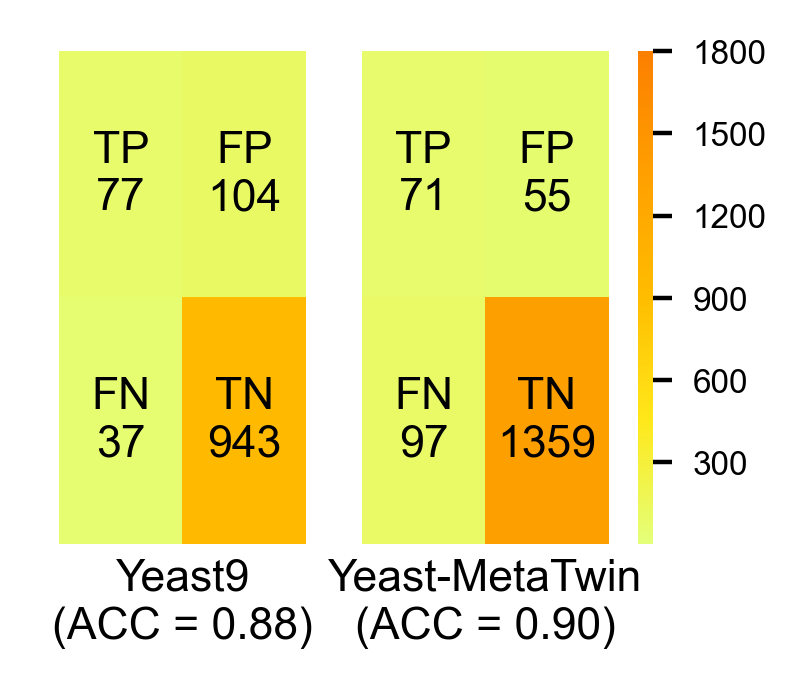

In [17]:
draw_confusion_matrix_figure(yeast8_TP, yeast8_TN, yeast8_FP, yeast8_FN, yeast8_Accuracy, 
                                 yeast8U_TP, yeast8U_TN, yeast8U_FP, yeast8U_FN, yeast8U_Accuracy, 
                                 gene_essential_allgene_confusion_matrix_figure_path, 1800)

In [18]:
break

SyntaxError: 'break' outside loop (668683560.py, line 4)

## Synthetic lethal

In [12]:
def draw_confusion_matrix_figure(yeast8_TP, yeast8_TN, yeast8_FP, yeast8_FN, yeast8_Accuracy, 
                                 yeast8U_TP, yeast8U_TN, yeast8U_FP, yeast8U_FN, yeast8U_Accuracy, 
                                 figure_path, vmax):
    # Assume you have two sets of confusion matrix data
    confusion_matrix1 = np.array([[yeast8_TP, yeast8_FP], [yeast8_FN, yeast8_TN]])
    confusion_matrix2 = np.array([[yeast8U_TP, yeast8U_FP], [yeast8U_FN, yeast8U_TN]])

    # Create a figure, set the subplot layout to 1 row and 2 columns, with the right subplot being narrower
    fig = plt.figure(figsize=(2, 1.6), dpi=400)
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['pdf.fonttype'] = 42
    
    gs = GridSpec(1, 3, width_ratios=[0.6, 0.6, 0.03])

    # First subplot
    ax1 = plt.subplot(gs[0])
    im1 = ax1.imshow(confusion_matrix1, cmap='Wistia', interpolation='nearest', vmin=1, vmax=vmax, aspect=2)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.grid(False)
    ax1.text(0, 0, f"TP\n{confusion_matrix1[0, 0]}", ha='center', va='center', fontsize=5, color='black')
    ax1.text(1, 0, f"FP\n{confusion_matrix1[0, 1]}", ha='center', va='center', fontsize=5, color='black')
    ax1.text(0, 1, f"FN\n{confusion_matrix1[1, 0]}", ha='center', va='center', fontsize=5, color='black')
    ax1.text(1, 1, f"TN\n{confusion_matrix1[1, 1]}", ha='center', va='center', fontsize=5, color='black')
    ax1.set_xlabel(f"Yeast8\n(ACC = {yeast8_Accuracy:.2f})", fontsize=8, labelpad=-1)
    # Add border to the image
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0)

    # Second subplot
    ax2 = plt.subplot(gs[1])
    im2 = ax2.imshow(confusion_matrix2, cmap='Wistia', interpolation='nearest', vmin=1, vmax=vmax, aspect=2)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.grid(False)
    ax2.text(0, 0, f"TP\n{confusion_matrix2[0, 0]}", ha='center', va='center', fontsize=5, color='black')
    ax2.text(1, 0, f"FP\n{confusion_matrix2[0, 1]}", ha='center', va='center', fontsize=5, color='black')
    ax2.text(0, 1, f"FN\n{confusion_matrix2[1, 0]}", ha='center', va='center', fontsize=5, color='black')
    ax2.text(1, 1, f"TN\n{confusion_matrix2[1, 1]}", ha='center', va='center', fontsize=5, color='black')
    ax2.set_xlabel(f"Yeast-MetaTwin\n(ACC = {yeast8U_Accuracy:.2f})", fontsize=8, labelpad=-1)
    # Add border to the image
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0)

    # Color bar
    cbar_ax = plt.subplot(gs[2])
    cbar = fig.colorbar(im2, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=6)
    cbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
    # Add border to the image
    for spine in cbar_ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0)

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.02)
    # Save the image to a file
    # plt.savefig(figure_path, dpi=400, bbox_inches='tight')
    plt.show()

In [13]:
yeast8_TP = 7552
yeast8_TN = 408621
yeast8_FP = 69397
yeast8_FN = 41672
yeast8_Accuracy = 0.79

yeast8U_TP = 3783
yeast8U_TN = 444691
yeast8U_FP = 33327
yeast8U_FN = 45441
yeast8U_Accuracy = 0.85

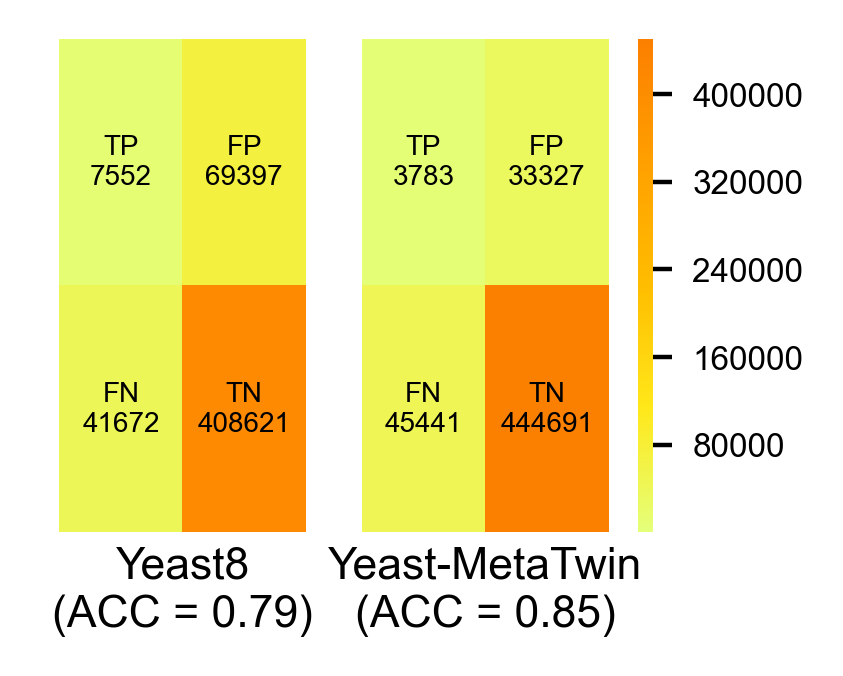

In [14]:
draw_confusion_matrix_figure(yeast8_TP, yeast8_TN, yeast8_FP, yeast8_FN, yeast8_Accuracy, 
                                 yeast8U_TP, yeast8U_TN, yeast8U_FP, yeast8U_FN, yeast8U_Accuracy, 
                                 'figure_path', 450000)